In [1]:
import pandas as pd
import numpy as np
import os 
from itertools import product
from tqdm.notebook import tqdm
import statsmodels.api as sm
from multiprocessing import Pool
import matplotlib.pyplot as plt
import datetime



import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Embedding
from keras.models import Model
from  keras.callbacks import ModelCheckpoint,Callback
from keras.callbacks import TensorBoard
# from keras import optimizers
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping

from input_data_prepare import *
# from input_data_prepare_old import *
# import input_data_prepare
import warnings
warnings.filterwarnings("ignore")
# import keras

In [ ]:
# 安装tensorflow， 有小bug，后续注意
# pip install -i https://pypi.tuna.tsinghua.edu.cn/simple tensorflow
# pip install -i https://pypi.tuna.tsinghua.edu.cn/simple tensorflow

In [195]:
tf.test.is_gpu_available()

False

In [30]:
# rnn_cell 有bug，版本问题

# output_size = 10
# batch_size = 32
# dim = 50
# cell = tf.nn.rnn_cell.BasicLSTMCell(num_units=output_size)
# input = tf.placeholder(dtype=tf.float32, shape=[batch_size, 50])
# h0 = cell.zero_state(batch_size=batch_size, dtype=tf.float32)
# new_h, new_state = cell.call(input, h0)

In [33]:
code_list = np.unique([x[0][1] for x in list(market_data_train.items())])

## data prepare

In [ ]:
# data 老版本手动导入data
# train_data = pd.read_pickle('train_input_n_label.pkl')    # 所有股票24天的数据
timesteps = 40

train_data = pd.read_pickle('train_data_code1.pkl')    # code==1的前一半时间数据J
test_data = pd.read_pickle('test_data_code1.pkl')    # code==1的前一半时间数据

x_train_list = []
for day in tqdm(range(len(train_data))):
    train_day = train_data[day] # 分出每天的train_data，避免跨天数据重叠
    for second in range(len(train_day)-timesteps):     # 每天按照时间分出sample   
        x_train_list.append(train_day[second:second + timesteps])

x_train = np.concatenate(x_train_list, axis=0).reshape(-1, 40, 14)[:,:,:-1]
y_train_sequential = np.concatenate(x_train_list, axis=0).reshape(-1, 40, 14)[:,:,-1]      # ytrain序列,shape = (247685,40, 3)
y_train_sequential = keras.utils.to_categorical(y_train_sequential, num_classes=3)        
y_train_last = y_train_sequential[:,-1,:]                                                   # 每个sample对最后一个ylabel,shape = (247685,3)
# y_train = y_train[:,-1,:]   # 
x_test_list = []
for day in tqdm(range(len(test_data))):
    test_day = test_data[day] # 分出每天的test_data，避免跨天数据重叠
    for second in range(len(test_day)-timesteps):     # 每天按照时间分出sample   
        x_test_list.append(test_day[second:second + timesteps])

x_test = np.concatenate(x_test_list, axis=0).reshape(-1, 40, 14)[:,:,:-1]
y_test_sequential = np.concatenate(x_test_list, axis=0).reshape(-1, 40, 14)[:,:,-1]      # ytest序列,shape = (247685,40, 3)
y_test_sequential = keras.utils.to_categorical(y_test_sequential, num_classes=3)        
y_test_last = y_test_sequential[:,-1,:]   

In [86]:
# pd.to_pickle(code_list, 'code_list.pkl', )
code_list = pd.read_pickle('code_list.pkl')
aa = pd.Series(range(len(code_list)),index = code_list)
aa[600050]

230

In [90]:
len(code_list)

400

In [91]:
code_list

array([     1,     12,     45,     63,     68,    150,    166,    301,
          413,    538,    541,    605,    616,    632,    637,    639,
          661,    688,    711,    713,    715,    720,    721,    755,
          756,    767,    768,    786,    790,    809,    810,    812,
          813,    820,    821,    825,    833,    856,    861,    877,
          919,    926,    927,    929,    935,    949,    952,    959,
          966,    971,    975,    987,   1696,   2016,   2021,   2023,
         2024,   2025,   2030,   2051,   2052,   2062,   2087,   2096,
         2118,   2120,   2134,   2135,   2137,   2139,   2142,   2145,
         2149,   2165,   2181,   2187,   2196,   2204,   2211,   2214,
         2238,   2246,   2252,   2269,   2273,   2278,   2279,   2336,
         2350,   2351,   2372,   2378,   2383,   2400,   2432,   2437,
         2440,   2446,   2453,   2465,   2473,   2474,   2492,   2502,
         2504,   2524,   2536,   2586,   2615,   2626,   2643,   2655,
      

In [100]:
# ?input_data_one_stock_all_days.train_n_test_data
code=603236
x_train,  y_train_sequential, y_train_last, x_test,  y_test_sequential, y_test_last = input_data_one_stock_all_days(code,part_fraction=10,k=60,d=40).train_n_test_data(ft_num=18)

In [99]:
code_list[338:]

array([603225, 603236, 603260, 603269, 603283, 603316, 603318, 603326,
       603336, 603338, 603345, 603363, 603365, 603369, 603389, 603416,
       603527, 603528, 603538, 603567, 603585, 603586, 603600, 603606,
       603608, 603619, 603629, 603650, 603676, 603683, 603686, 603688,
       603689, 603701, 603708, 603712, 603733, 603739, 603787, 603810,
       603816, 603819, 603822, 603861, 603882, 603888, 603898, 603918,
       603970, 603976, 603980, 603989, 688001, 688009, 688026, 688033,
       688058, 688068, 688081, 688168, 688310, 688369])

In [26]:
# code=300454
input_data_one_stock_all_days(300454,part_fraction=10,k=60,d=40).train_n_test_data(ft_num=18)

(array([[[-1.39219568e+00, -1.20929621e+00, -3.85423026e-01, ...,
           1.61562334e+00,  2.40951576e+00,  1.03757810e+00],
         [-1.39184813e+00, -1.20909613e+00, -1.35187849e-01, ...,
           1.97836238e+00,  2.43448335e+00,  1.05354152e+00],
         [-1.39184813e+00, -1.20909613e+00, -3.85423026e-01, ...,
           2.07579856e+00,  2.53439843e+00,  1.11742381e+00],
         ...,
         [-1.38454959e+00, -1.20487160e+00,  1.15047327e-01, ...,
           2.08669281e+00,  4.51622307e-01,  1.87469204e-01],
         [-1.38446270e+00, -1.20482114e+00, -3.22864232e-01, ...,
           2.01433691e+00,  2.67055243e-01,  1.63783374e-01],
         [-1.38359382e+00, -1.20431661e+00,  2.40164916e-01, ...,
           1.86851760e+00,  2.10249325e-02,  1.39190641e-02]],
 
        [[-1.38889396e+00, -1.20738817e+00, -1.00702610e-02, ...,
           3.17718846e+00,  1.39060978e+00,  7.02218835e-01],
         [-1.38828575e+00, -1.20703611e+00,  5.24885332e-02, ...,
           3.24759861

In [3]:
x_train.shape

(24864, 20, 17)

In [4]:
y_train_last.shape

(10263, 3)

In [18]:
x_train.shape        # 整体十抽一


(24652, 60, 17)

In [16]:
x_train.shape        # oneday onestock函数内部十抽一

(17767, 20, 17)

In [14]:
x_train.shape        # part_fraction=1

(183686, 20, 17)

In [13]:
# 新版函数
code=45
x_train1, y_train_sequential1, y_train_last1, x_test1, y_test_sequential1, y_test_last1 = input_data_prepare.input_data_one_stock_all_days(code).train_n_test_data(ft_num=18,part_fraction=1)

In [10]:
x_train   # new version

array([[[-1.56898414, -1.58188588, -0.06350854, ..., -0.2901302 ,
         -0.15702953, -0.18063128],
        [-1.56715767, -1.58001757,  0.83599246, ..., -0.11351011,
         -0.15530192, -0.10239428],
        [-1.56555184, -1.57837496,  0.6873325 , ...,  0.24293582,
         -0.51118886, -0.01217204],
        ...,
        [-1.55819207, -1.57085138, -0.12293348, ..., -0.24075254,
         -0.33600956, -0.29315938],
        [-1.55803578, -1.5706916 , -0.28937302, ..., -0.31823749,
         -0.32287975, -0.31113724],
        [-1.55776717, -1.57041691, -0.21369449, ..., -0.32773319,
         -0.35639532, -0.24954642]],

       [[-1.56715767, -1.58001757,  0.83599246, ..., -0.11351011,
         -0.15530192, -0.10239428],
        [-1.56555184, -1.57837496,  0.6873325 , ...,  0.24293582,
         -0.51118886, -0.01217204],
        [-1.56513178, -1.57794545, -0.11164824, ...,  0.06631573,
         -0.30733129, -0.08741273],
        ...,
        [-1.55803578, -1.5706916 , -0.28937302, ..., -

In [3]:
x_train   # old version  code1


array([[[-1.56898414, -1.58188588, -0.06350854, ..., -0.29013683,
         -0.15705301, -0.18064268],
        [-1.56715767, -1.58001757,  0.83599246, ..., -0.11352047,
         -0.15532547, -0.10240656],
        [-1.56555184, -1.57837496,  0.6873325 , ...,  0.24291793,
         -0.51119776, -0.01218533],
        ...,
        [-1.55819207, -1.57085138, -0.12293348, ..., -0.24076022,
         -0.33602567, -0.29316953],
        [-1.55803578, -1.5706916 , -0.28937302, ..., -0.31824352,
         -0.3228964 , -0.31114719],
        [-1.55776717, -1.57041691, -0.21369449, ..., -0.32773903,
         -0.35641059, -0.24955706]],

       [[-1.56715767, -1.58001757,  0.83599246, ..., -0.11352047,
         -0.15532547, -0.10240656],
        [-1.56555184, -1.57837496,  0.6873325 , ...,  0.24291793,
         -0.51119776, -0.01218533],
        [-1.56513178, -1.57794545, -0.11164824, ...,  0.06630157,
         -0.30734858, -0.08742518],
        ...,
        [-1.55803578, -1.5706916 , -0.28937302, ..., -

In [13]:
x_train[0][:5][:,-5:]

array([[ 0.6361297 ,  0.00811517, -0.15569439,  1.82534051,  1.85506906],
       [ 0.67083479, -0.12445615, -0.07442041,  1.57522218,  1.88315644],
       [ 0.08084834, -0.20852576, -0.24900896, -0.37847993,  1.69497096],
       [-0.06664827, -0.49306908,  0.03996519, -0.73142469, -0.17564891],
       [-0.057972  , -0.36049776, -0.04130879, -0.62026099, -0.2037363 ]])

In [3]:
# tmp_68 = input_data_one_stock_all_days(68, part_fraction=10).train_n_test_data(ft_num=18)

In [14]:
y_train_last.shape

(248637, 3)

In [4]:
x_train

array([[[-2.1904407 , -2.19373295,  0.30692802, ..., -0.36669586,
         -0.23270212, -0.28410052],
        [-2.18520253, -2.18848051,  2.32079012, ..., -0.15682391,
         -0.23082381, -0.22419102],
        [-2.18059711, -2.18386258,  1.98796041, ...,  0.26672929,
         -0.61775559, -0.15510389],
        ...,
        [-2.15948986, -2.16271135,  0.17388354, ..., -0.30802198,
         -0.427295  , -0.37026823],
        [-2.15904162, -2.16226215, -0.19875226, ..., -0.40009484,
         -0.41301984, -0.38403467],
        [-2.15827127, -2.16148989, -0.02931818, ..., -0.41137828,
         -0.44945905, -0.33687187]],

       [[-2.18520253, -2.18848051,  2.32079012, ..., -0.15682391,
         -0.23082381, -0.22419102],
        [-2.18059711, -2.18386258,  1.98796041, ...,  0.26672929,
         -0.61775559, -0.15510389],
        [-2.17939242, -2.1826551 ,  0.19914968, ...,  0.05685733,
         -0.39611506, -0.21271898],
        ...,
        [-2.15904162, -2.16226215, -0.19875226, ..., -

## sequential1 try, only model, no data

In [ ]:
# sequential 1
from keras.models import Sequential
from tensorflow.keras.layers import Dense
model = Sequential()

model.add(Dense(units=128, activation='relu', input_dim=13))
model.add(Dense(units=32))
model.add(Dense(units=3, activation='softmax'))


model.compile(loss = 'categorical_crossentropy',optimizer='sgd',metrics=['accuracy'])
model.summary()


In [13]:
?model.compile

Signature:
model.compile(
    optimizer='rmsprop',
    loss=None,
    metrics=None,
    loss_weights=None,
    weighted_metrics=None,
    run_eagerly=None,
    steps_per_execution=None,
    **kwargs,
)
Docstring:
Configures the model for training.

Example:

```python
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(),
                       tf.keras.metrics.FalseNegatives()])
```

Args:
    optimizer: String (name of optimizer) or optimizer instance. See
      `tf.keras.optimizers`.
    loss: Loss function. Maybe be a string (name of loss function), or
      a `tf.keras.losses.Loss` instance. See `tf.keras.losses`. A loss
      function is any callable with the signature `loss = fn(y_true,
      y_pred)`, where `y_true` are the ground truth values, and
      `y_pred` are the model's predictions.
      `y_true` should have shape
      `(batch_size, d0, ..

## sueuqntial 2 try

In [34]:
# sequential 2
from keras.models import Sequential
from keras.layers import Dense, Activation

model = Sequential()
model.add(Dense(32, input_shape = (784,)))
model.add(Activation('relu'))
model.add(Dense(10))
model.add(Activation('softmax'))
model.summary()


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 32)                25120     
                                                                 
 activation_2 (Activation)   (None, 32)                0         
                                                                 
 dense_10 (Dense)            (None, 10)                330       
                                                                 
 activation_3 (Activation)   (None, 10)                0         
                                                                 
Total params: 25,450
Trainable params: 25,450
Non-trainable params: 0
_________________________________________________________________


In [162]:
model.fit(x_train, y_train, epochs=5, batch_size=1024)


Epoch 1/5


ValueError: in user code:

    File "/home/zdang1/.local/lib/python3.7/site-packages/keras/engine/training.py", line 878, in train_function  *
        return step_function(self, iterator)
    File "/home/zdang1/.local/lib/python3.7/site-packages/keras/engine/training.py", line 867, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/zdang1/.local/lib/python3.7/site-packages/keras/engine/training.py", line 860, in run_step  **
        outputs = model.train_step(data)
    File "/home/zdang1/.local/lib/python3.7/site-packages/keras/engine/training.py", line 808, in train_step
        y_pred = self(x, training=True)
    File "/home/zdang1/.local/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/zdang1/.local/lib/python3.7/site-packages/keras/engine/input_spec.py", line 263, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "sequential_16" is incompatible with the layer: expected shape=(None, 8, 13), found shape=(None, 40, 13)


## sequential 3 try

In [46]:
# sequential 3
model = keras.Sequential(
    [
        layers.Dense(128, activation="relu"),
        layers.Dense(128, activation="relu"),
        layers.Dense(32),
        layers.Dense(3, activation="softmax"),
        layers.Dense(1),
    ]
)

x = x_train[0].reshape((1,-1))
y = model(x)#y_train[0]
model.summary()
print("Number of weights after calling the model:", len(model.weights))

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_32 (Dense)            (1, 128)                  1792      
                                                                 
 dense_33 (Dense)            (1, 128)                  16512     
                                                                 
 dense_34 (Dense)            (1, 32)                   4128      
                                                                 
 dense_35 (Dense)            (1, 3)                    99        
                                                                 
 dense_36 (Dense)            (1, 1)                    4         
                                                                 
Total params: 22,535
Trainable params: 22,535
Non-trainable params: 0
_________________________________________________________________
Number of weights after calling the model: 10


## sequential 4 try

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Embedding
from keras.layers import LSTM

max_features = 1024

model = Sequential()
model.add(Embedding(max_features, output_dim=256))
model.add(LSTM(128))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

model.fit(x_train, y_train, batch_size=16, epochs=10)
# score = model.evaluate(x_test, y_test, batch_size=16)

## sequential 5 try

In [200]:
# check 训练集和测试集时间范围
input_data_one_stock_all_days(code).get_time_train_test()

(array([20191204, 20191205, 20191206, 20191209, 20191210, 20191211,
        20191213, 20191216, 20191219, 20191225, 20191227, 20191231,
        20200102, 20200103, 20200106, 20200108, 20200109, 20200113,
        20200114, 20200115, 20200116, 20200120, 20200121, 20200123,
        20200203, 20200206, 20200207, 20200210, 20200211, 20200213,
        20200214, 20200217, 20200218, 20200219, 20200220, 20200221,
        20200225, 20200227, 20200228, 20200305, 20200306, 20200309,
        20200310, 20200311, 20200313, 20200316, 20200318, 20200319,
        20200323, 20200324, 20200403, 20200407, 20200409]),
 array([20200414, 20200415, 20200417, 20200422, 20200423, 20200424,
        20200428, 20200429, 20200430, 20200506, 20200508, 20200512,
        20200514, 20200519, 20200521, 20200522, 20200525, 20200526,
        20200527, 20200528, 20200608, 20200612, 20200615, 20200617,
        20200619, 20200622, 20200623, 20200707, 20200708, 20200710,
        20200713, 20200714, 20200715, 20200716, 20200717

In [ ]:
# sequential 5 try
data_dim = 14      # 特征数 * 13
batchsize = 1024   # 初始batchsize取1024

timesteps = 60         # 根据batchsize 决定时间窗口长度 
num_classes = 3

# 期望输入数据尺寸: (batch_size, timesteps, data_dim)
model = Sequential()
model.add(LSTM(128, return_sequences=True,
               input_shape=(timesteps, data_dim)))  # 返回维度为 128 的向量序列

model.add(Dropout(0.5))    # dropout 0.5

model.add(LSTM(128, return_sequences=True))  # 返回维度为 128 的向量序列

model.add(Dense(32))  # 维度为 32 的全连接层
model.add(Dense(3, activation='softmax'))    # softmax 后的最终结果

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])
    
model.fit(x_train, y_train_sequential,          # 对y序列进行预测
          batch_size=1024, epochs=5
          ,validation_data=(x_test, y_test_sequential))

In [ ]:
filepath = 'D:\\machineTest\\model-ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5'
# filepath = 'D:\\machineTest\\model-ep{epoch:03d}-loss{loss:.3f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
print(model.get_config())
# [{'class_name': 'Dense', 'config': {'bias_regularizer': None, 'use_bias': True, 'kernel_regularizer': None, 'batch_input_shape': (None, 784), 'trainable': True, 'kernel_constraint': None, 'bias_constraint': None, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'distribution': 'uniform', 'mode': 'fan_avg', 'seed': None}}, 'activity_regularizer': None, 'units': 64, 'dtype': 'float32', 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'activation': 'relu', 'name': 'dense_1'}}, {'class_name': 'Dense', 'config': {'bias_regularizer': None, 'use_bias': True, 'kernel_regularizer': None, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_constraint': None, 'bias_constraint': None, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'distribution': 'uniform', 'mode': 'fan_avg', 'seed': None}}, 'activity_regularizer': None, 'trainable': True, 'units': 10, 'activation': 'softmax', 'name': 'dense_2'}}]
# model.fit(x_train, y_train, epochs=1, batch_size=128, callbacks=[checkpoint],validation_data=(x_valid, y_valid))
model.fit(x_train, y_train, epochs=1,validation_data=(x_valid, y_valid),steps_per_epoch=10,validation_steps=1)
# score = model.evaluate(x_test, y_test, batch_size=128)


In [6]:
# 数据十抽一检验
x_train_1in10 = x_train[::10,:,:-3]
y_train_last_1in10 = y_train_last[::10,:]
x_test_1in10 = x_test[::10,:,:-3]
y_test_last_1in10 = y_test_last[::10,:]

# time_steps减小
# x_train_1in10 = x_train_1in10[:,-30:,:]
# y_train_last_1in10 = y_train_last[::10,:]
# x_test_1in10 = x_test_1in10[:,-30:,:]
# y_test_last_1in10 = y_test_last[::10,:]

In [80]:
# 对每个sample的最后一个ylabel进行预测
model1 = Sequential()

# model1.add(Dense(32))  # 维度为 32 的全连接层
# timesteps = x_train.shape[1]
# data_dim = x_train.shape[2]-3-5
# data_dim = 5

# model1.add(LSTM(128, return_sequences=True,
#                input_shape=(timesteps, data_dim)))  # 返回维度为 128 的向量序列

# model1.add(Dropout(0.5))    # dropout 0.5

# model1.add(LSTM(128, return_sequences=False))  # 返回维度为 128 的向量序列

# model1.add(Dense(32))  # 维度为 32 的全连接层
# model1.add(Dense(3, activation='softmax'))    # softmax 后的最终结果





model1.add(LSTM(512, return_sequences=True))  # 返回维度为 1024 的向量序列
model1.add(LSTM(512//2, return_sequences=True))  # 返回维度为 512 的向量序列
model1.add(LSTM(256//2, return_sequences=False))  # 返回维度为 256 的向量序列

model1.add(Dense(128))  # 维度为 128 的全连接层
model1.add(Dense(6))  # 维度为 6 的全连接层
model1.add(Dense(3, activation='softmax'))    # softmax 后的最终结果

model1_opt = optimizers.Adam(lr = 0.0005)
model1.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

early_stop = EarlyStopping(min_delta=0.001,patience=2)   

# 对y序列进行预测 
his = model1.fit(x_train[:,:,:-3], y_train_last,          
          batch_size=1024, epochs=30,
          validation_data=(x_test[:,:,:-3], y_test_last),
          callbacks=[early_stop])

# model1.save('model_3l_3d_ndp.h5')       # 

Epoch 1/30
25/25 [==============================] - 84s 3s/step - loss: 1.0450 - accuracy: 0.4392 - val_loss: 1.0151 - val_accuracy: 0.4727
Epoch 2/30
25/25 [==============================] - 80s 3s/step - loss: 0.9961 - accuracy: 0.4998 - val_loss: 0.9649 - val_accuracy: 0.5360
Epoch 3/30
25/25 [==============================] - 80s 3s/step - loss: 0.9504 - accuracy: 0.5458 - val_loss: 0.9193 - val_accuracy: 0.5640
Epoch 4/30
25/25 [==============================] - 77s 3s/step - loss: 0.9263 - accuracy: 0.5660 - val_loss: 0.9184 - val_accuracy: 0.5667
Epoch 5/30
25/25 [==============================] - 79s 3s/step - loss: 0.9145 - accuracy: 0.5705 - val_loss: 0.9043 - val_accuracy: 0.5776
Epoch 6/30
25/25 [==============================] - 80s 3s/step - loss: 0.9029 - accuracy: 0.5808 - val_loss: 0.8990 - val_accuracy: 0.5789
Epoch 7/30
25/25 [==============================] - 81s 3s/step - loss: 0.8943 - accuracy: 0.5837 - val_loss: 0.9100 - val_accuracy: 0.5745
Epoch 8/30
25/25 [==

,best_train_epoch,train_loss,train_acc,best_val_epoch,val_loss,val_acc
0,7,0.8879,0.586,5,0.899,0.5789


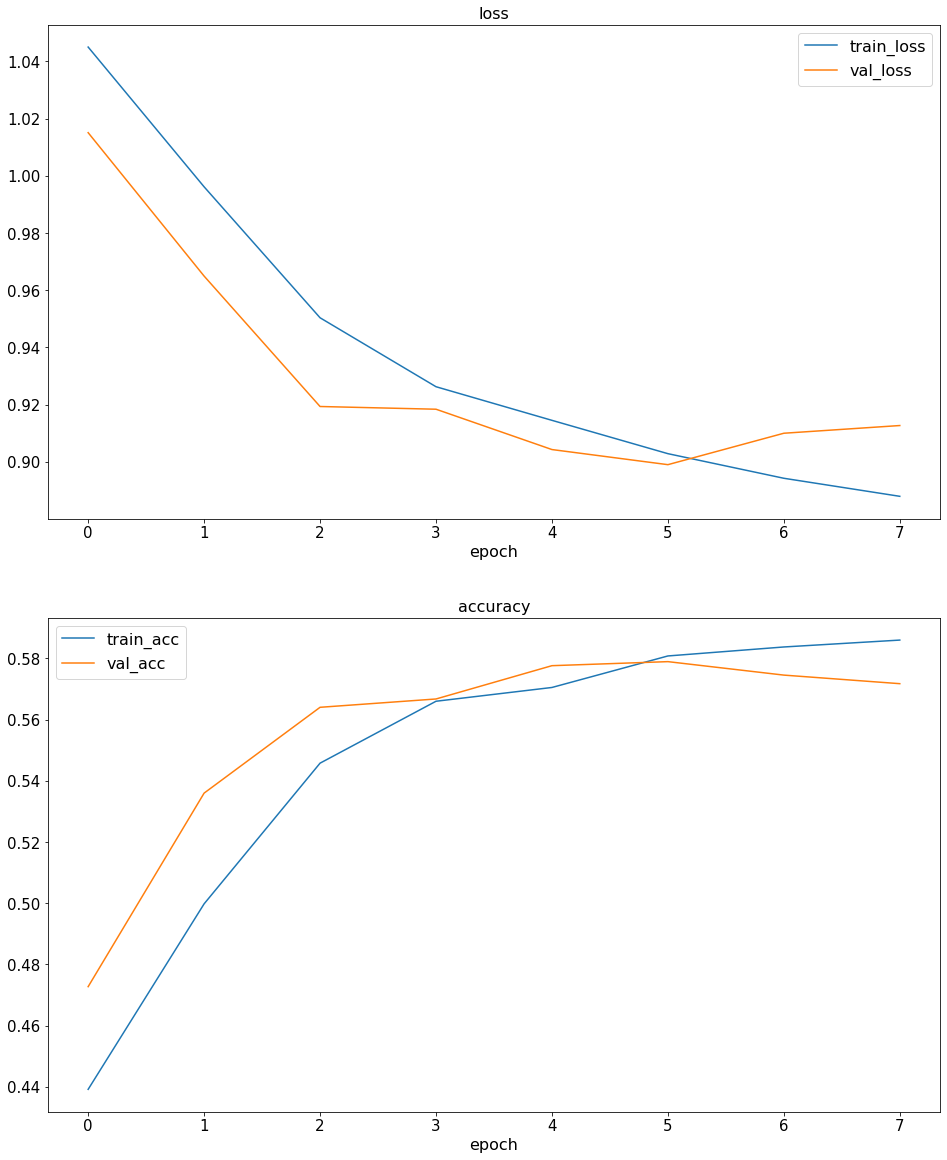

In [81]:
plt.figure(figsize=(16,20))
ax1 = plt.subplot(2,1,1)
ax1.plot(his.history['loss'],label='train_loss')
ax1.plot(his.history['val_loss'], label='val_loss')
ax1.set_title('loss',fontdict={'size':16})

plt.legend(prop = {'size':16})
plt.tick_params(labelsize=15)
plt.xticks(range(0,len(his.history['val_loss'])))
plt.xlabel('epoch',size=16)

ax2 = plt.subplot(2,1,2)
ax2.plot(his.history['accuracy'],label='train_acc')
ax2.plot(his.history['val_accuracy'], label='val_acc')
plt.legend(prop = {'size':16})
plt.tick_params(labelsize=15)
plt.xticks(range(0,len(his.history['val_loss'])))
plt.xlabel('epoch',size=16)
ax2.set_title('accuracy',fontdict={'size':16})

# plt.set_ticks_position('top')
# plt.subplots_adjust(hspace=0.1)
plt.savefig('loss.png' , bbox_inches='tight')

df_result = pd.concat([pd.Series(x) for x in his.history.values()],axis=1)
df_result.columns = ['train_loss','train_acc','val_loss','val_acc']
df_result.index.names=['epoch']
df_result.iloc[-1:,:].round(4)

pd.DataFrame([[np.argmax(df_result.train_acc),df_result.train_loss.min(), df_result.train_acc.max(),np.argmax(df_result.val_acc),df_result.val_loss.min(), df_result.val_acc.max()]],columns=['best_train_epoch','train_loss','train_acc','best_val_epoch','val_loss','val_acc']).round(4)

# his.history

In [47]:
model1.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 20, 128)           70656     
                                                                 
 dropout_2 (Dropout)         (None, 20, 128)           0         
                                                                 
 lstm_13 (LSTM)              (None, 128)               131584    
                                                                 
 dense_16 (Dense)            (None, 32)                4128      
                                                                 
 dense_17 (Dense)            (None, 3)                 99        
                                                                 
Total params: 206,467
Trainable params: 206,467
Non-trainable params: 0
_________________________________________________________________


In [18]:
output = model1.predict(x_test)

In [19]:
real_y_test = pd.Series(np.sum(y_test_last*np.array([0,1,-1]),axis=1))
real_y_test.value_counts()

-1.0    9302
 1.0    9283
 0.0    6414
dtype: int64

In [10]:
pd.DataFrame(output)

,0,1,2
0,1.193191e-04,0.966696,0.033185
1,6.909878e-06,0.969516,0.030477
2,5.175472e-04,0.950537,0.048946
3,1.095064e-03,0.952688,0.046217
4,4.563471e-04,0.253517,0.746026
...,...,...,...
24859,5.404971e-06,0.002705,0.997290
24860,8.626701e-01,0.131511,0.005819
24861,3.988392e-01,0.575369,0.025791
24862,9.650972e-07,0.999373,0.000626


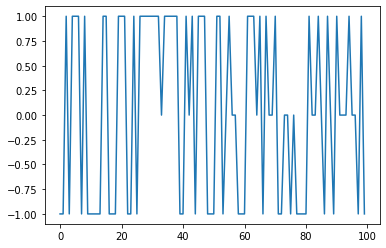

In [20]:
plt.plot(real_y_test[:100])

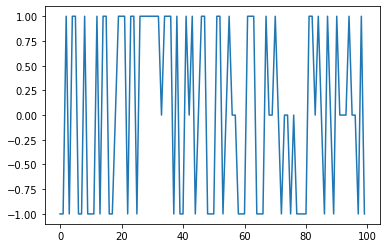

In [21]:
plt.plot(pd.DataFrame(output).apply(lambda x: 0 if np.argmax(x)==0 else (1 if np.argmax(x)==1 else -1),axis=1)[:100])

In [27]:
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 20, 32)            480       
                                                                 
 lstm_1 (LSTM)               (None, 128)               82432     
                                                                 
 dense_4 (Dense)             (None, 32)                4128      
                                                                 
 dense_5 (Dense)             (None, 3)                 99        
                                                                 
Total params: 87,139
Trainable params: 87,139
Non-trainable params: 0
_________________________________________________________________


## check factor perfomance

In [51]:
x_train.shape

(24864, 20, 17)

In [74]:
y_ic = np.sum(y_train_last * np.array([0,1,-1]), axis=1)
y_ic = x_train[:,-1,-3]

x_ic = np.concatenate([x_train[:,-i,:-8] for i in range(1,21)],axis=1)

In [53]:
pd.Series(y_ic).value_counts()

-1.0    9630
 1.0    9330
 0.0    5904
dtype: int64

In [76]:
x_ic.shape

(24864, 180)

In [75]:
ols_model = sm.OLS(y_ic, x_ic)
ols_f = ols_model.fit()
ols_f.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.066
Model:                            OLS   Adj. R-squared:                  0.060
Method:                 Least Squares   F-statistic:                     10.38
Date:                Wed, 12 Jan 2022   Prob (F-statistic):          5.51e-251
Time:                        16:27:19   Log-Likelihood:             1.4371e+05
No. Observations:               24864   AIC:                        -2.871e+05
Df Residuals:                   24694   BIC:                        -2.857e+05
Df Model:                         169                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             3.8944      5.156      0.755      0.450      -6.212      14.000
x2            -4.2509      5.502     -0.773      0.440     -15.035       6.533
x3            -0.0056      0.008     -0.733      0.463      -0.021       0.009
x4             0.0062      0.008      0.753      0.452      -0.010       0.022
x5            -0.2297      0.482     -0.477      0.633      -1.174       0.714
x6             0.2311      0.485      0.477      0.634      -0.719       1.181
x7            7.3e-05   6.13e-06     11.903      0.000     6.1e-05     8.5e-05
x8          -5.61e-05   5.91e-06     -9.494      0.000   -6.77e-05   -4.45e-05
x9            -0.1409      0.295     -0.477      0.634      -0.720       0.438
x10          -10.7156      6.354     -1.686      0.092     -23.170       1.739
x11           11.5695      6.694      1.728      0.084      -1.551      24.690
x12            0.0101      0.006      1.834      0.067      -0.001       0.021
x13           -0.0109      0.006     -1.916      0.055      -0.022       0.000
x14           -0.2572      0.539     -0.477      0.633      -1.314       0.800
x15            0.2588      0.543      0.477      0.633      -0.805       1.323
x16         6.464e-05   5.96e-06     10.842      0.000     5.3e-05    7.63e-05
x17        -6.559e-05   5.99e-06    -10.950      0.000   -7.73e-05   -5.38e-05
x18           -0.0169      0.035     -0.477      0.634      -0.086       0.052
x19            3.4505      5.096      0.677      0.498      -6.538      13.439
x20           -3.7089      5.336     -0.695      0.487     -14.167       6.749
x21            0.0053      0.005      1.026      0.305      -0.005       0.015
x22           -0.0057      0.006     -1.021      0.307      -0.017       0.005
x23           -0.2297      0.482     -0.477      0.633      -1.174       0.714
x24            0.2312      0.485      0.477      0.633      -0.719       1.181
x25         6.423e-05   5.88e-06     10.916      0.000    5.27e-05    7.58e-05
x26        -5.884e-05   6.04e-06     -9.743      0.000   -7.07e-05    -4.7e-05
x27            0.0168      0.035      0.476      0.634      -0.053       0.086
x28            7.4319      7.488      0.992      0.321      -7.245      22.109
x29           -7.9459      8.014     -0.991      0.321     -23.654       7.762
x30           -0.0060      0.010     -0.611      0.541      -0.025       0.013
x31            0.0065      0.011      0.611      0.541      -0.014       0.027
x32           -0.0006      0.000     -1.323      0.186      -0.001       0.000
x33            0.0006      0.000      1.438      0.150      -0.000       0.001
x34         5.888e-05   6.02e-06      9.774      0.000    4.71e-05    7.07e-05
x35        -6.267e-05    6.6e-06     -9.490      0.000   -7.56e-05   -4.97e-05
x36            0.1405      0.295      0.476      0.634      -0.439       0.720
x3

In [83]:
market_data = pd.read_pickle('/code/20211027_alldays_market_data_cleanadd/market_data_train.pkl')

In [89]:
keys_list_code1 = [x for x in list(market_data.keys()) if x[1] == 1]
code1_data = [x[1] for x in list(market_data.items()) if x[0][1]==1]

In [95]:
np.concatenate(code1_data).shape

(504643, 30)

# all stock


In [113]:
all_stock_result = {}
# os.listdir('/code/task4-imbalance/train_result')

['train_test_result_1.pkl',
 'train_test_result_2453.pkl',
 'train_test_result_12.pkl',
 'train_test_result_45.pkl',
 'train_test_result_63.pkl',
 'train_test_result_68.pkl',
 'train_test_result_150.pkl',
 'train_test_result_166.pkl',
 'train_test_result_301.pkl',
 'train_test_result_413.pkl',
 'train_test_result_538.pkl',
 'train_test_result_541.pkl',
 'train_test_result_605.pkl',
 'train_test_result_616.pkl',
 'train_test_result_632.pkl',
 'train_test_result_637.pkl',
 'train_test_result_639.pkl',
 'train_test_result_661.pkl',
 'train_test_result_688.pkl',
 'train_test_result_711.pkl',
 'train_test_result_713.pkl',
 'train_test_result_715.pkl',
 'train_test_result_720.pkl',
 'train_test_result_721.pkl',
 'train_test_result_755.pkl',
 'train_test_result_756.pkl',
 'train_test_result_767.pkl',
 'train_test_result_768.pkl',
 'train_test_result_786.pkl',
 'train_test_result_790.pkl',
 'train_test_result_809.pkl',
 'train_test_result_810.pkl',
 'train_test_result_812.pkl',
 'train_test_re

In [111]:
all_stock_result_codelist = [x[18:-4] for x in os.listdir('/code/task4-imbalance/train_result')]
all_stock_result_codelist.sort()
all_stock_result_codelist

['1',
 '12',
 '150',
 '166',
 '1696',
 '2016',
 '2021',
 '2023',
 '2024',
 '2025',
 '2030',
 '2051',
 '2052',
 '2062',
 '2087',
 '2096',
 '2118',
 '2120',
 '2134',
 '2135',
 '2137',
 '2139',
 '2142',
 '2145',
 '2149',
 '2165',
 '2181',
 '2187',
 '2196',
 '2204',
 '2211',
 '2214',
 '2238',
 '2246',
 '2252',
 '2269',
 '2273',
 '2278',
 '2279',
 '2336',
 '2350',
 '2351',
 '2372',
 '2378',
 '2383',
 '2400',
 '2432',
 '2437',
 '2440',
 '2446',
 '2453',
 '2465',
 '2473',
 '2474',
 '2492',
 '2502',
 '2504',
 '2524',
 '2536',
 '2586',
 '2615',
 '2626',
 '2643',
 '2655',
 '2678',
 '2681',
 '2694',
 '2695',
 '2712',
 '2716',
 '2721',
 '2724',
 '2737',
 '2795',
 '2803',
 '2809',
 '2819',
 '2860',
 '2870',
 '2871',
 '2873',
 '2876',
 '2896',
 '2899',
 '2902',
 '2905',
 '2918',
 '2938',
 '2950',
 '2951',
 '2956',
 '2972',
 '300001',
 '300058',
 '300061',
 '300064',
 '300068',
 '300083',
 '300087',
 '300108',
 '300116',
 '300120',
 '300123',
 '300132',
 '300153',
 '300171',
 '300177',
 '300191',
 '3

In [114]:
for code_path in os.listdir('/code/task4-imbalance/train_result'):
    all_stock_result[code_path[18:-4]] = pd.read_pickle(os.path.join('/code/task4-imbalance/train_result', code_path))

In [123]:
x_train_split = [x[0] for x in list(all_stock_result.values())]
x_train_all = np.concatenate(x_train_split)

y_train_split = [y[2] for y in list(all_stock_result.values())]
y_train_all = np.concatenate(y_train_split)

x_test_split = [x[3] for x in list(all_stock_result.values())]
x_test_all = np.concatenate(x_test_split)

y_test_split = [y[5] for y in list(all_stock_result.values())]
y_test_all = np.concatenate(y_test_split)


In [1]:
# 对每个sample的最后一个ylabel进行预测
model1 = Sequential()

# model1.add(Dense(32))  # 维度为 32 的全连接层
timesteps = x_train.shape[1]
data_dim = x_train.shape[2]-3
# data_dim = 5

model1.add(LSTM(128, return_sequences=True,
               input_shape=(timesteps, data_dim)))  # 返回维度为 128 的向量序列

model1.add(Dropout(0.5))    # dropout 0.5

model1.add(LSTM(128, return_sequences=False))  # 返回维度为 128 的向量序列

model1.add(Dense(32))  # 维度为 32 的全连接层
model1.add(Dense(3, activation='softmax'))    # softmax 后的最终结果


# model1.add(LSTM(512, return_sequences=True))  # 返回维度为 1024 的向量序列
# model1.add(LSTM(512//2, return_sequences=True))  # 返回维度为 512 的向量序列
# model1.add(LSTM(256//2, return_sequences=False))  # 返回维度为 256 的向量序列

# model1.add(Dense(128))  # 维度为 128 的全连接层
# model1.add(Dense(6))  # 维度为 6 的全连接层
# model1.add(Dense(3, activation='softmax'))    # softmax 后的最终结果

model1_opt = optimizers.Adam(lr = 0.0005)
model1.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

early_stop = EarlyStopping(min_delta=0.002,patience=2)   

# 对y序列进行预测 
his = model1.fit(x_train_all[:,:,:-3], y_train_all,          
          batch_size=1024, epochs=30,
          validation_data=(x_test_all[:,:,:-3], y_test_all),
          callbacks=[early_stop])

# model1.save('model_3l_3d_ndp.h5')       # 

NameError: name 'Sequential' is not defined

In [ ]:
plt.figure(figsize=(16,20))
ax1 = plt.subplot(2,1,1)
ax1.plot(his.history['loss'],label='train_loss')
ax1.plot(his.history['val_loss'], label='val_loss')
ax1.set_title('loss',fontdict={'size':16})

plt.legend(prop = {'size':16})
plt.tick_params(labelsize=15)
plt.xticks(range(0,len(his.history['val_loss'])))
plt.xlabel('epoch',size=16)

ax2 = plt.subplot(2,1,2)
ax2.plot(his.history['accuracy'],label='train_acc')
ax2.plot(his.history['val_accuracy'], label='val_acc')
plt.legend(prop = {'size':16})
plt.tick_params(labelsize=15)
plt.xticks(range(0,len(his.history['val_loss'])))
plt.xlabel('epoch',size=16)
ax2.set_title('accuracy',fontdict={'size':16})

# plt.set_ticks_position('top')
# plt.subplots_adjust(hspace=0.1)
plt.savefig('loss.png' , bbox_inches='tight')

df_result = pd.concat([pd.Series(x) for x in his.history.values()],axis=1)
df_result.columns = ['train_loss','train_acc','val_loss','val_acc']
df_result.index.names=['epoch']
df_result.iloc[-1:,:].round(4)

pd.DataFrame([[np.argmax(df_result.train_acc),df_result.train_loss.min(), df_result.train_acc.max(),np.argmax(df_result.val_acc),df_result.val_loss.min(), df_result.val_acc.max()]],columns=['best_train_epoch','train_loss','train_acc','best_val_epoch','val_loss','val_acc']).round(4)

# his.history